<a href="https://colab.research.google.com/github/TarikKocak/DogBreedIdentification/blob/main/dogbreedpred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available ")

GPU available


In [ ]:
import wandb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import torch
import torchvision
import torch.optim as optim
from torchvision import models
import random

IMG_SIZE = 224  # Resize images
BATCH_SIZE = 32
NUM_EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
base_path='drive/MyDrive/data/cropped'

In [ ]:
from torch.utils.data import Dataset, DataLoader, Subset
import math

In [ ]:
class DogDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        img = cv2.imread(file_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = torch.from_numpy(img).permute(2, 0, 1).float()  # Convert to PyTorch tensor (C, H, W)
        one_hot_label = np.eye(len(self.labels))[label - 1]
        one_hot_label = torch.from_numpy(one_hot_label).float()
        return img, one_hot_label

def load_and_split_data(base_path):
    labels = {}
    labels_r = {}
    idx = 0
    combined_data = []

    # Assign labels based on folder names in the train folder
    for folder in os.listdir(f'{base_path}/train'):
        folder_path = os.path.join(f'{base_path}/train', folder)
        if not os.path.isdir(folder_path):  # Ensure it's a folder
            continue
        idx += 1
        labels[folder] = idx
        labels_r[idx] = folder
        print(f"Assigned label {idx} to folder '{folder}'")

        # Add train folder data
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            combined_data.append((file_path, idx))

    # Add test folder data
    for folder in os.listdir(f'{base_path}/test'):
        folder_path = os.path.join(f'{base_path}/test', folder)
        if not os.path.isdir(folder_path):  # Ensure it's a folder
            continue
        label = labels.get(folder, None)
        if label is None:
            print(f"Skipping unknown folder '{folder}' in test data")
            continue

        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            combined_data.append((file_path, label))

    # Shuffle combined data
    random.shuffle(combined_data)

    # Split data into 10 equal parts
    num_parts = 10
    part_size = len(combined_data) // num_parts
    parts = [combined_data[i * part_size:(i + 1) * part_size] for i in range(num_parts)]

    # Assign data to train, validation, and test sets
    train_parts = parts[:7]  # 7 parts for training
    val_parts = parts[7:8]  # 1 part for validation
    test_parts = parts[8:]  # 2 parts for testing

    train_data = [item for part in train_parts for item in part]
    val_data = [item for part in val_parts for item in part]
    test_data = [item for part in test_parts for item in part]

    # Create datasets and data loaders
    train_dataset = DogDataset(train_data, labels)
    val_dataset = DogDataset(val_data, labels)
    test_dataset = DogDataset(test_data, labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, test_loader, labels, labels_r


In [ ]:
train_loader, val_loader, test_loader, labels, labels_r = load_and_split_data(base_path)

Assigned label 1 to folder 'n02085620-Chihuahua'
Assigned label 2 to folder 'n02085782-Japanese_spaniel'
Assigned label 3 to folder 'n02085936-Maltese_dog'
Assigned label 4 to folder 'n02086079-Pekinese'
Assigned label 5 to folder 'n02086240-Shih-Tzu'
Assigned label 6 to folder 'n02086646-Blenheim_spaniel'
Assigned label 7 to folder 'n02086910-papillon'
Assigned label 8 to folder 'n02087046-toy_terrier'
Assigned label 9 to folder 'n02087394-Rhodesian_ridgeback'
Assigned label 10 to folder 'n02088094-Afghan_hound'
Assigned label 11 to folder 'n02088238-basset'
Assigned label 12 to folder 'n02088364-beagle'
Assigned label 13 to folder 'n02088466-bloodhound'
Assigned label 14 to folder 'n02088632-bluetick'
Assigned label 15 to folder 'n02089078-black-and-tan_coonhound'
Assigned label 16 to folder 'n02089867-Walker_hound'
Assigned label 17 to folder 'n02089973-English_foxhound'
Assigned label 18 to folder 'n02090379-redbone'
Assigned label 19 to folder 'n02090622-borzoi'
Assigned label 20 

In [ ]:
test_folder_path = "drive/MyDrive/data/cropped/test"
file_count = 0
for folder in os.listdir(test_folder_path):
    folder_path = os.path.join(test_folder_path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        file_count += len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

print(f"Total number of files in the train folder: {file_count}")

Total number of files in the train folder: 8580


In [ ]:
train_folder_path = "drive/MyDrive/data/cropped/train"
file_count = 0
for folder in os.listdir(train_folder_path):
    folder_path = os.path.join(train_folder_path, folder)
    if os.path.isdir(folder_path):  # Ensure it's a folder
        file_count += len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

print(f"Total number of files in the train folder: {file_count}")

Total number of files in the train folder: 12000


In [ ]:
def show_images(images, labels, labels_r):
    # Convert images tensor to NumPy array
    images = images.permute(0, 2, 3, 1).numpy()  # Change from (N, C, H, W) to (N, H, W, C)
    images = images.astype(np.uint8)  # Ensure the data type is uint8 for display

    # Convert one-hot labels back to class indices
    label_indices = labels.argmax(dim=1).numpy()  # Get the index of the class for each label

    # Determine grid size for displaying images
    num_images = images.shape[0]
    grid_size = math.ceil(math.sqrt(num_images))  # Calculate grid size

    plt.figure(figsize=(grid_size * 3, grid_size * 3))  # Adjust figure size

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)  # Create a dynamic grid layout
        plt.imshow(images[i])

        # Use the class index to fetch the breed name from labels_r
        label_index = label_indices[i] + 1  # Convert tensor to integer
        #breed_name = labels_r[label_index].split("-")[1]  # Extract breed name from label string
        breed_name = "-".join(labels_r[label_index].split("-", 1)[1:])
        plt.title(breed_name)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

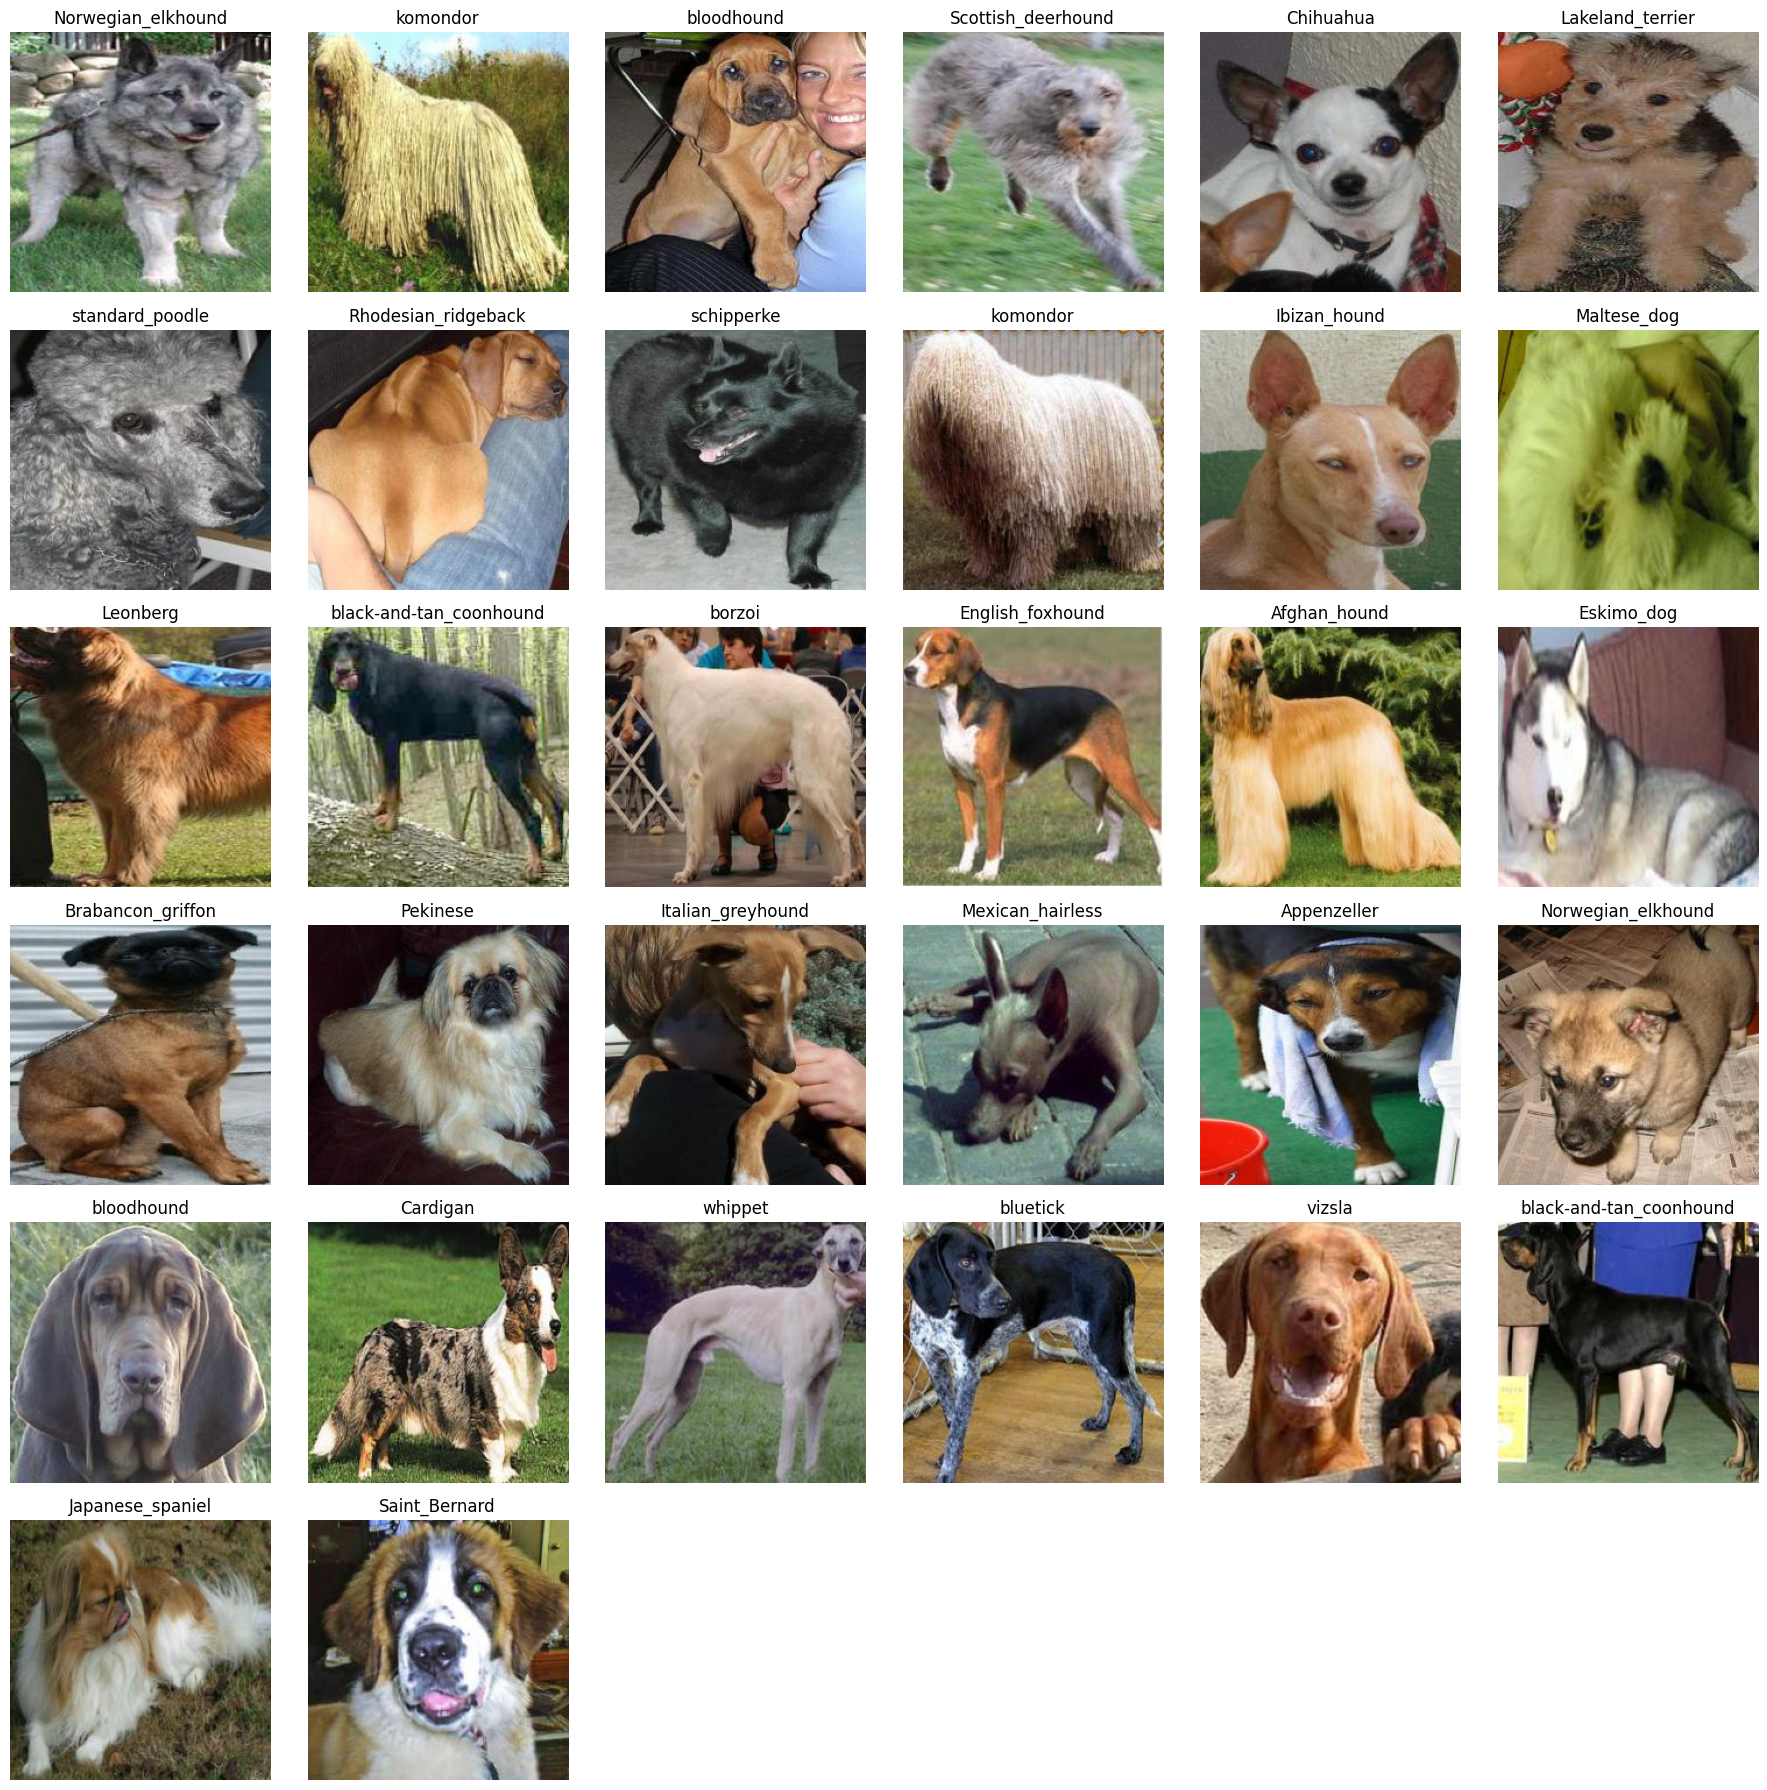

In [ ]:
data_iter = iter(train_loader)  # Get an iterator for the DataLoader
images, img_labels = next(data_iter)  # Get a batch of images and labels

show_images(images, img_labels, labels_r)  # Display the images with their labels

In [ ]:
num_samples_train = len(train_loader.dataset)
num_samples_test = len(test_loader.dataset)
num_samples_valid = len(val_loader.dataset)

drop_last = False

# Calculate the number of batches
if drop_last:
    num_batches_train = num_samples_train // BATCH_SIZE
else:
    num_batches_train = math.ceil(num_samples_train / BATCH_SIZE)

if drop_last:
    num_batches_valid = num_samples_valid // BATCH_SIZE
else:
    num_batches_valid = math.ceil(num_samples_valid / BATCH_SIZE)

if drop_last:
    num_batches_test = num_samples_test // BATCH_SIZE
else:
    num_batches_test = math.ceil(num_samples_test / BATCH_SIZE)

print(f"Total number of batches in train_loader: {num_batches_train}")
print(f"Total number of batches in val_loader: {num_batches_valid}")
print(f"Total number of batches in test_loader: {num_batches_test}")

Total number of batches in train_loader: 451
Total number of batches in val_loader: 65
Total number of batches in test_loader: 129


In [ ]:
total_images = len(train_loader.dataset)
batch_size = train_loader.batch_size
drop_last = train_loader.drop_last  # This should match the DataLoader's drop_last setting

if drop_last:
    last_batch_size = batch_size  # If drop_last=True, all batches are full-sized
else:
    last_batch_size = total_images % batch_size or batch_size

print(f"Size of the last batch of Train: {last_batch_size}")

Size of the last batch of Train: 6


In [ ]:
total_images = len(val_loader.dataset)
batch_size = val_loader.batch_size
drop_last = val_loader.drop_last  # This should match the DataLoader's drop_last setting

if drop_last:
    last_batch_size = batch_size  # If drop_last=True, all batches are full-sized
else:
    last_batch_size = total_images % batch_size or batch_size

print(f"Size of the last batch of Validation: {last_batch_size}")

Size of the last batch of Validation: 10


In [ ]:
total_images = len(test_loader.dataset)
batch_size = test_loader.batch_size
drop_last = test_loader.drop_last  # This should match the DataLoader's drop_last setting

if drop_last:
    last_batch_size = batch_size  # If drop_last=True, all batches are full-sized
else:
    last_batch_size = total_images % batch_size or batch_size

print(f"Size of the last batch of Test: {last_batch_size}")

Size of the last batch of Test: 20


In [ ]:
len(train_loader),len(val_loader),len(test_loader)

(451, 65, 129)

In [ ]:
from torchvision import models
import timm

def pretrained_model_resnet(num_classes):

    model = models.resnet50(pretrained=True)  # Load ResNet50
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


def pretrained_model_vgg(num_classes):

    model = models.vgg19(pretrained=True)  # Load VGG19
    model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    return model


def pretrained_model_xception(num_classes):

    model = timm.create_model('xception', pretrained=True) # Load xception
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def pretrained_model_mobilenetv2(num_classes):
    model = timm.create_model('mobilenetv2_100', pretrained=True)  # Load MobileNetV2
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Adjust the classifier for your number of classes
    return model


In [ ]:

class EarlyStopping:
    def __init__(self, patience=5, delta=0, model_name='model', save_dir='driver/MyDriver/', verbose=False):
        self.patience = patience
        self.delta = delta
        self.model_name = model_name
        self.save_dir = save_dir
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

        # Ensure the save directory exists
        os.makedirs(self.save_dir, exist_ok=True)

        # Construct the full path for the saved model
        self.path = os.path.join(self.save_dir, f'{self.model_name}_best_model.pt')

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased to {val_loss:.4f}. Saving model as {self.path}...")
        torch.save(model.state_dict(), self.path)


# Train and Plotting History

In [ ]:
def plot_history(history, save_path=None):

    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"History chart saved to {save_path}")

    plt.show()


def train_model(model, train_loader, val_loader, num_epochs, device, model_name='model', save_dir='driver/mydriver/', patience=5):
    import torch.nn as nn
    import torch.optim as optim

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    model = model.to(device)

    # Initialize EarlyStopping with the model name and directory
    early_stopping = EarlyStopping(patience=patience, model_name=model_name, save_dir=save_dir, verbose=True)

    # Initialize history tracking
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct = 0.0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.argmax(dim=1).to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.argmax(dim=1).to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Calculate metrics
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Save metrics to history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model.")
            break

    # Load the best model
    model.load_state_dict(torch.load(early_stopping.path))

    # Save the plot in the specified directory
    save_path = f'{save_dir}/history_chart.png'
    plot_history(history, save_path)

    return model


In [ ]:
num_classes = len(labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = pretrained_model_resnet(num_classes)
model_vgg = pretrained_model_vgg(num_classes)
model_xception = pretrained_model_xception(num_classes)
model_mobilenetv2 = pretrained_model_mobilenetv2(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

## Training on Pretrained Model

Epoch 1/20, Train Loss: 1.7272, Train Acc: 0.6111, Val Loss: 0.8986, Val Acc: 0.7284
Validation loss decreased to 0.8986. Saving model as drive/MyDrive/resnet50_best_model.pt...
Epoch 2/20, Train Loss: 0.5887, Train Acc: 0.8335, Val Loss: 0.7572, Val Acc: 0.7692
Validation loss decreased to 0.7572. Saving model as drive/MyDrive/resnet50_best_model.pt...
Epoch 3/20, Train Loss: 0.2975, Train Acc: 0.9141, Val Loss: 0.7313, Val Acc: 0.7741
Validation loss decreased to 0.7313. Saving model as drive/MyDrive/resnet50_best_model.pt...
Epoch 4/20, Train Loss: 0.1850, Train Acc: 0.9473, Val Loss: 0.8398, Val Acc: 0.7629
Epoch 5/20, Train Loss: 0.1268, Train Acc: 0.9675, Val Loss: 0.9107, Val Acc: 0.7522
Epoch 6/20, Train Loss: 0.1114, Train Acc: 0.9727, Val Loss: 0.9138, Val Acc: 0.7595
Epoch 7/20, Train Loss: 0.1290, Train Acc: 0.9645, Val Loss: 0.9523, Val Acc: 0.7536
Epoch 8/20, Train Loss: 0.1033, Train Acc: 0.9725, Val Loss: 1.0094, Val Acc: 0.7502
Epoch 9/20, Train Loss: 0.0840, Train Acc

<ipython-input-10-4aed821ebcdb>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


History chart saved to drive/MyDrive//history_chart.png


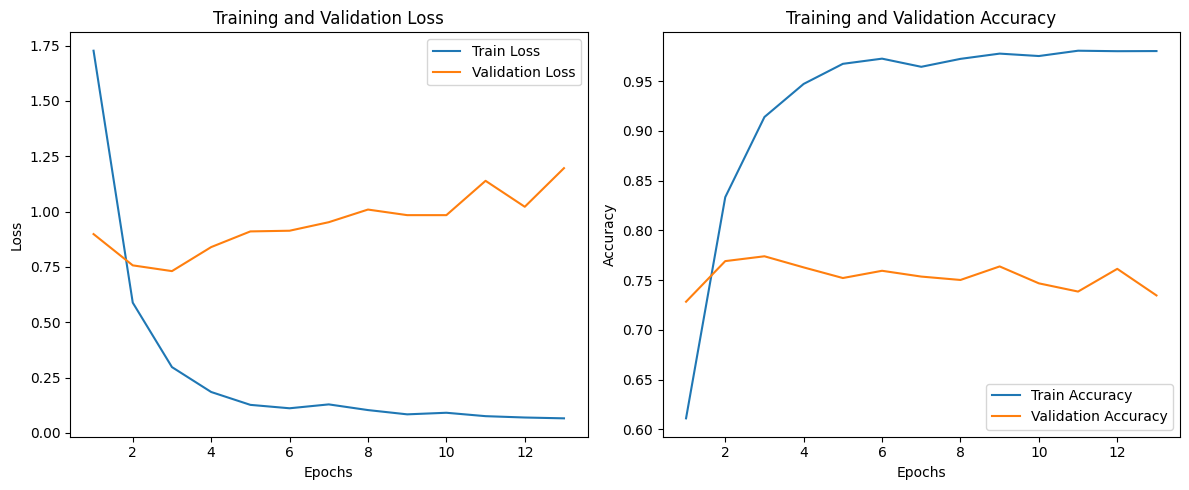

In [ ]:
trained_model_resnet50 = train_model(model_resnet, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=device, model_name="resnet50", save_dir="drive/MyDrive/" ,patience=10) # image size 224x224, epoch=20

Epoch 1/20, Train Loss: 4.5133, Train Acc: 0.0330, Val Loss: 3.6681, Val Acc: 0.1045
Validation loss decreased to 3.6681. Saving model as drive/MyDrive/vgg19_best_model.pt...
Epoch 2/20, Train Loss: 3.1206, Train Acc: 0.1858, Val Loss: 2.5191, Val Acc: 0.2940
Validation loss decreased to 2.5191. Saving model as drive/MyDrive/vgg19_best_model.pt...
Epoch 3/20, Train Loss: 2.1268, Train Acc: 0.3816, Val Loss: 1.8564, Val Acc: 0.4684
Validation loss decreased to 1.8564. Saving model as drive/MyDrive/vgg19_best_model.pt...
Epoch 4/20, Train Loss: 1.4824, Train Acc: 0.5463, Val Loss: 1.7019, Val Acc: 0.5155
Validation loss decreased to 1.7019. Saving model as drive/MyDrive/vgg19_best_model.pt...
Epoch 5/20, Train Loss: 1.0278, Train Acc: 0.6797, Val Loss: 1.5309, Val Acc: 0.5666
Validation loss decreased to 1.5309. Saving model as drive/MyDrive/vgg19_best_model.pt...
Epoch 6/20, Train Loss: 0.7501, Train Acc: 0.7613, Val Loss: 1.5236, Val Acc: 0.5748
Validation loss decreased to 1.5236. Sav

<ipython-input-10-4aed821ebcdb>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


History chart saved to drive/MyDrive//history_chart.png


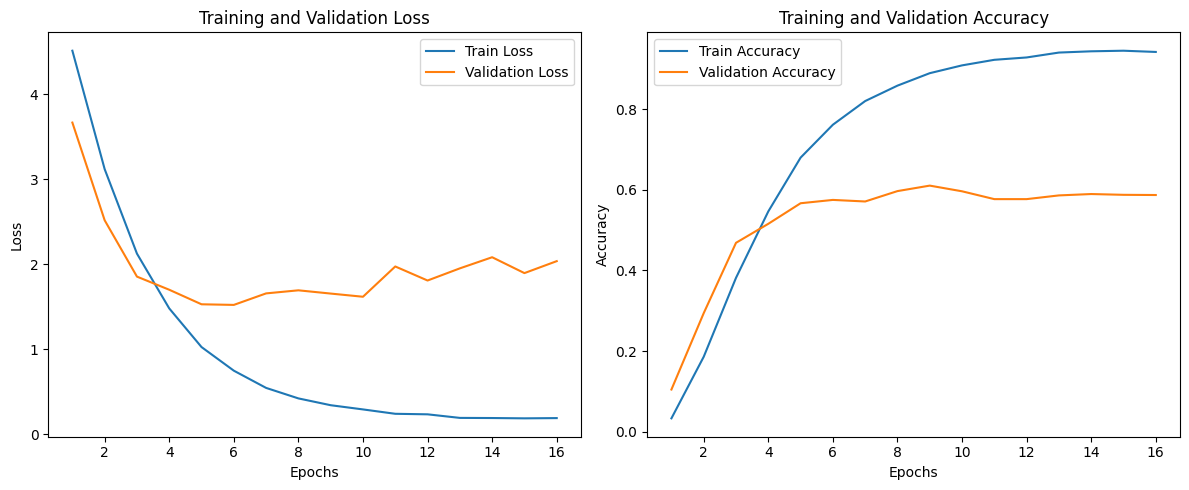

In [ ]:
trained_model_vgg19= train_model(model_vgg, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=device, model_name="vgg19", save_dir="drive/MyDrive/" ,patience=10) #

Epoch 1/20, Train Loss: 3.2334, Train Acc: 0.3451, Val Loss: 1.7582, Val Acc: 0.6176
Validation loss decreased to 1.7582. Saving model as drive/MyDrive/mobilenetv2_best_model.pt...
Epoch 2/20, Train Loss: 1.4212, Train Acc: 0.6658, Val Loss: 1.1171, Val Acc: 0.7099
Validation loss decreased to 1.1171. Saving model as drive/MyDrive/mobilenetv2_best_model.pt...
Epoch 3/20, Train Loss: 0.9244, Train Acc: 0.7682, Val Loss: 0.9318, Val Acc: 0.7328
Validation loss decreased to 0.9318. Saving model as drive/MyDrive/mobilenetv2_best_model.pt...
Epoch 4/20, Train Loss: 0.6616, Train Acc: 0.8314, Val Loss: 0.8325, Val Acc: 0.7507
Validation loss decreased to 0.8325. Saving model as drive/MyDrive/mobilenetv2_best_model.pt...
Epoch 5/20, Train Loss: 0.4792, Train Acc: 0.8789, Val Loss: 0.8107, Val Acc: 0.7546
Validation loss decreased to 0.8107. Saving model as drive/MyDrive/mobilenetv2_best_model.pt...
Epoch 6/20, Train Loss: 0.3540, Train Acc: 0.9179, Val Loss: 0.7924, Val Acc: 0.7643
Validation

<ipython-input-10-4aed821ebcdb>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


History chart saved to drive/MyDrive//history_chart.png


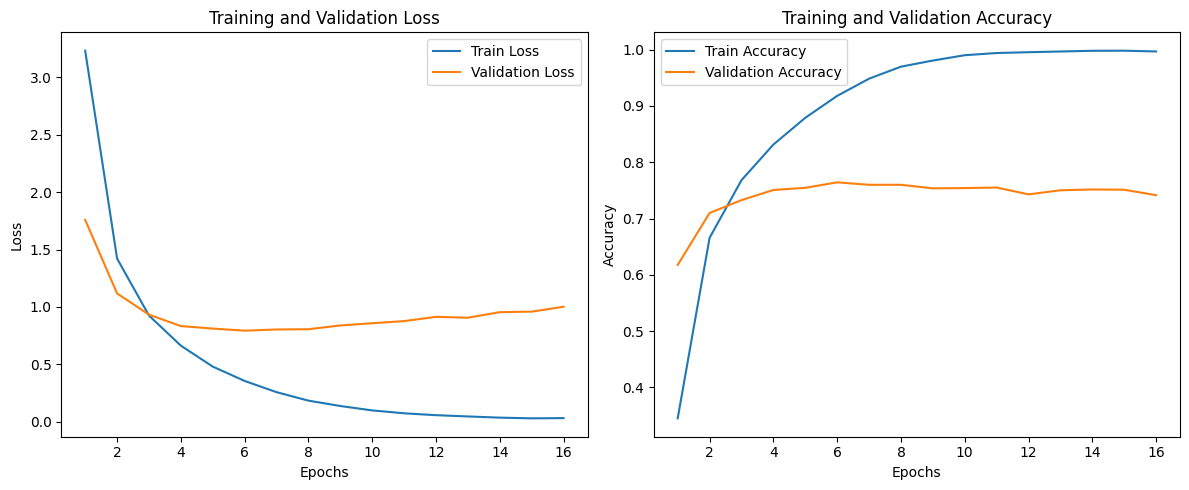

In [ ]:
trained_model_mobilnetv2 = train_model(model_mobilenetv2, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=device, model_name="mobilenetv2", save_dir="drive/MyDrive/" ,patience=10) #

Epoch 1/20, Train Loss: 1.8755, Train Acc: 0.6850, Val Loss: 0.6228, Val Acc: 0.8450
Validation loss decreased to 0.6228. Saving model as drive/MyDrive/xception_best_model.pt...
Epoch 2/20, Train Loss: 0.3788, Train Acc: 0.9086, Val Loss: 0.5176, Val Acc: 0.8562
Validation loss decreased to 0.5176. Saving model as drive/MyDrive/xception_best_model.pt...
Epoch 3/20, Train Loss: 0.1404, Train Acc: 0.9669, Val Loss: 0.5193, Val Acc: 0.8518
Epoch 4/20, Train Loss: 0.0616, Train Acc: 0.9892, Val Loss: 0.5516, Val Acc: 0.8552
Epoch 5/20, Train Loss: 0.0371, Train Acc: 0.9933, Val Loss: 0.5525, Val Acc: 0.8610
Epoch 6/20, Train Loss: 0.0240, Train Acc: 0.9967, Val Loss: 0.5850, Val Acc: 0.8440
Epoch 7/20, Train Loss: 0.0190, Train Acc: 0.9963, Val Loss: 0.6169, Val Acc: 0.8499
Epoch 8/20, Train Loss: 0.0366, Train Acc: 0.9914, Val Loss: 0.6883, Val Acc: 0.8299
Epoch 9/20, Train Loss: 0.0306, Train Acc: 0.9935, Val Loss: 0.6954, Val Acc: 0.8333
Epoch 10/20, Train Loss: 0.0239, Train Acc: 0.994

<ipython-input-14-4aed821ebcdb>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping.path))


History chart saved to drive/MyDrive//history_chart.png


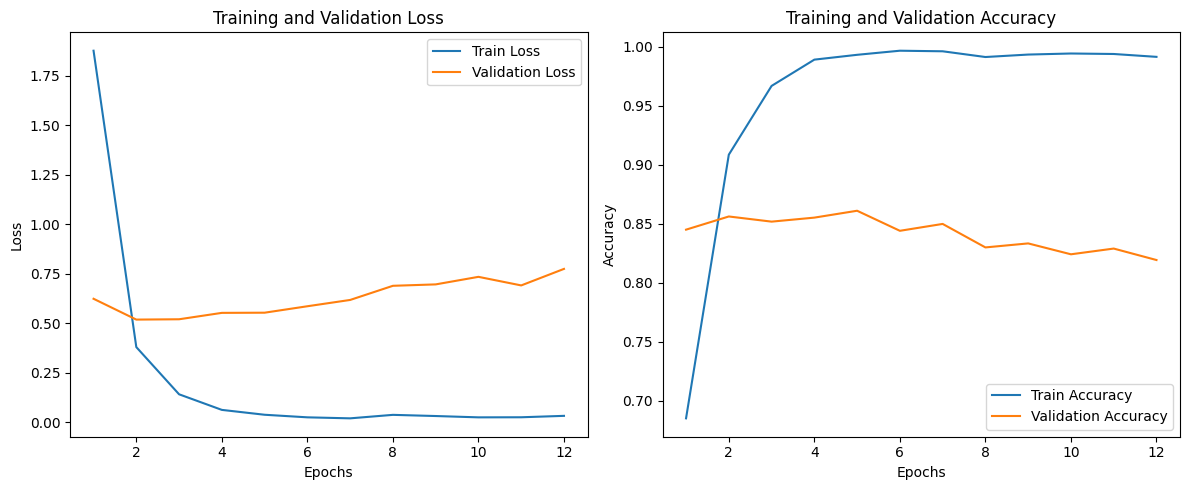

In [ ]:
trained_model_xception = train_model(model_xception, train_loader, val_loader, num_epochs=NUM_EPOCHS, device=device, model_name="xception", save_dir="drive/MyDrive/" ,patience=10) #

## Train on Custom CNN Model
Based on https://www.researchgate.net/publication/374158183_Deep_Learning-Based_Classification_of_Image_Data_Sets_Containing_111_Different_Seeds

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048*4)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Define the CNN model
model = Sequential([
    Reshape((224, 224, 3), input_shape=(3, 224, 224)),  # Reshape the input
    Conv2D(64, (3, 3), activation=tf.nn.gelu, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(64, (3, 3), activation=tf.nn.gelu, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation=tf.nn.gelu, padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(512, activation=tf.nn.gelu),
    Dropout(0.5),
    Dense(256, activation=tf.nn.gelu),
    Dense(120, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

1 Physical GPUs, 1 Logical GPUs


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,655,480 (197.05 MB)

 Trainable params: 51,655,480 (197.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Simplified train_model function with custom EarlyStopping
def train_custom_model(model, train_data, val_data, num_epochs, batch_size, save_dir='driver/mydriver/', patience=5):
    early_stopping = EarlyStopping(patience=patience, model_name='custom_model', save_dir=save_dir, verbose=True)

    # Train the model using the fit method
    history = model.fit(
        train_data,  # Training data
        epochs=num_epochs,
        validation_data=val_data,  # Validation data
        batch_size=batch_size
    )

    # Check early stopping at the end of each epoch
    for epoch in range(num_epochs):
        val_loss = history.history['val_loss'][epoch]
        early_stopping(val_loss, model)  # Call early stopping

        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model.")
            model = tf.keras.models.load_model(early_stopping.path)  # Restore the best model
            break

    # Save the training history plot
    save_path = f'{save_dir}/custom_model_history_chart.png'
    plot_history(history, save_path)

    return model

In [ ]:
trained_custom_model = train_custom_model(model, train_loader, val_loader, num_epochs=50, batch_size=BATCH_SIZE, save_dir="drive/MyDrive/" ,patience=50)

Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.2310 - loss: 3.5955 - val_accuracy: 0.0214 - val_loss: 5.6027
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 133ms/step - accuracy: 0.2539 - loss: 3.4937 - val_accuracy: 0.0228 - val_loss: 5.8835
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 61s 135ms/step - accuracy: 0.2845 - loss: 3.3478 - val_accuracy: 0.0253 - val_loss: 5.8930
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.3056 - loss: 3.2139 - val_accuracy: 0.0233 - val_loss: 6.0448
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.3341 - loss: 3.1109 - val_accuracy: 0.0253 - val_loss: 6.2402
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.3595 - loss: 2.9646 - val_accuracy: 0.0277 - val_loss: 6.5423
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 60s 132ms/step - accuracy: 0.3798 - loss: 2.8581 - val_accuracy: 0.0267 - val_loss: 6.7156
Epoch 8/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 61s 134ms/step - accuracy: 0.3927 - loss: 2

AttributeError: 'Sequential' object has no attribute 'state_dict'

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss, test_correct = 0.0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.argmax(dim=1).to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_correct += (outputs.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = test_correct / len(test_loader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

# Evaluation of RESNET50

In [ ]:
evaluate_model(trained_model_resnet50, test_loader, device) # resnet50's accuracy

Test Loss: 0.7209, Test Accuracy: 0.7903


(0.7209409801072852, 0.7903304178814383)

# Evaluation of VGG19

In [ ]:
evaluate_model(trained_model_vgg19, test_loader, device) # vgg19's accuracy

Test Loss: 1.4794, Test Accuracy: 0.5850


(1.4793746087902275, 0.5850340136054422)

# Evaluation of MobilNETV2

In [ ]:
evaluate_model(trained_model_mobilnetv2, test_loader, device) # mobilenetv2's accuracy

Test Loss: 0.7566, Test Accuracy: 0.7607


(0.7566205179968546, 0.760689990281827)

# Evaluation of Xception

In [ ]:
evaluate_model(trained_model_xception, test_loader, device) # xception's accuracy

Test Loss: 0.5050, Test Accuracy: 0.8469


(0.5050368319994719, 0.8469387755102041)

In [ ]:
def visualize_random_predictions(model, test_loader, labels_r, device, num_images=10, global_title=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import random

    model.eval()

    # Gather all images and labels from the test loader
    all_imgs, all_labels = [], []
    for imgs, labels in test_loader:
        all_imgs.append(imgs)
        all_labels.append(labels)
    all_imgs = torch.cat(all_imgs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Randomly sample indices
    indices = random.sample(range(len(all_imgs)), num_images)
    imgs = all_imgs[indices]
    true_labels = all_labels[indices]

    # Move data to the device
    imgs = imgs.to(device)
    true_labels = true_labels.argmax(dim=1).to(device)

    with torch.no_grad():
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        top_probs, top_classes = probs.topk(5, dim=1)  # Get top 5 predictions

    # Move data back to CPU for visualization
    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy().astype(np.uint8)
    true_labels = true_labels.cpu().numpy()
    top_probs = top_probs.cpu().numpy()
    top_classes = top_classes.cpu().numpy()

    # Function to clean label names
    def clean_label(label):
        return label.split('-')[-1]  # Extract the part after the dash

    # Plotting
    fig, axes = plt.subplots(num_images // 2, 4, figsize=(12, 3 * (num_images // 2)))  # Compact figure size
    axes = axes.reshape(-1, 4)  # Ensure axes are handled as pairs (image, bar)

    for i in range(num_images):
        row, col_img, col_bar = i // 2, (i % 2) * 2, (i % 2) * 2 + 1
        img_ax = axes[row, col_img]
        bar_ax = axes[row, col_bar]

        # Display the image
        img_ax.imshow(imgs[i], interpolation="nearest")
        img_ax.axis('off')
        true_label = clean_label(labels_r[true_labels[i] + 1])  # Clean the true label
        img_ax.set_title(f"True: {true_label}", fontsize=8)

        # Display bar plot for top 5 predictions
        breed_names = [clean_label(labels_r[top_classes[i, j] + 1]) for j in range(5)]
        bar_ax.barh(breed_names, top_probs[i], color='skyblue')
        bar_ax.set_xlim(0, 1)
        bar_ax.set_xlabel("Probability", fontsize=6)
        bar_ax.set_title("Top 5 Predictions", fontsize=8)
        bar_ax.tick_params(axis="y", labelsize=6)

    # Add global title
    if global_title:
        plt.suptitle(global_title, fontsize=16, y=1.02)

    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust spacing
    plt.tight_layout()
    plt.show()


In [ ]:
mobilenet_v2_model = pretrained_model_mobilenetv2(num_classes).to(device)
resnet50_model = pretrained_model_resnet(num_classes).to(device)
vgg19_model = pretrained_model_vgg(num_classes).to(device)
xception_model = pretrained_model_xception(num_classes).to(device)

# Load the state dictionaries
mobilenet_v2_model.load_state_dict(torch.load("/content/drive/MyDrive/mobilnetv2.pt"))
resnet50_model.load_state_dict(torch.load("/content/drive/MyDrive/resnet50.pt"))
vgg19_model.load_state_dict(torch.load("/content/drive/MyDrive/vgg19.pt"))
xception_model.load_state_dict(torch.load("/content/drive/MyDrive/xception.pt"))

# Set the models to evaluation mode
mobilenet_v2_model.eval()
resnet50_model.eval()
vgg19_model.eval()
xception_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
 

Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Conv

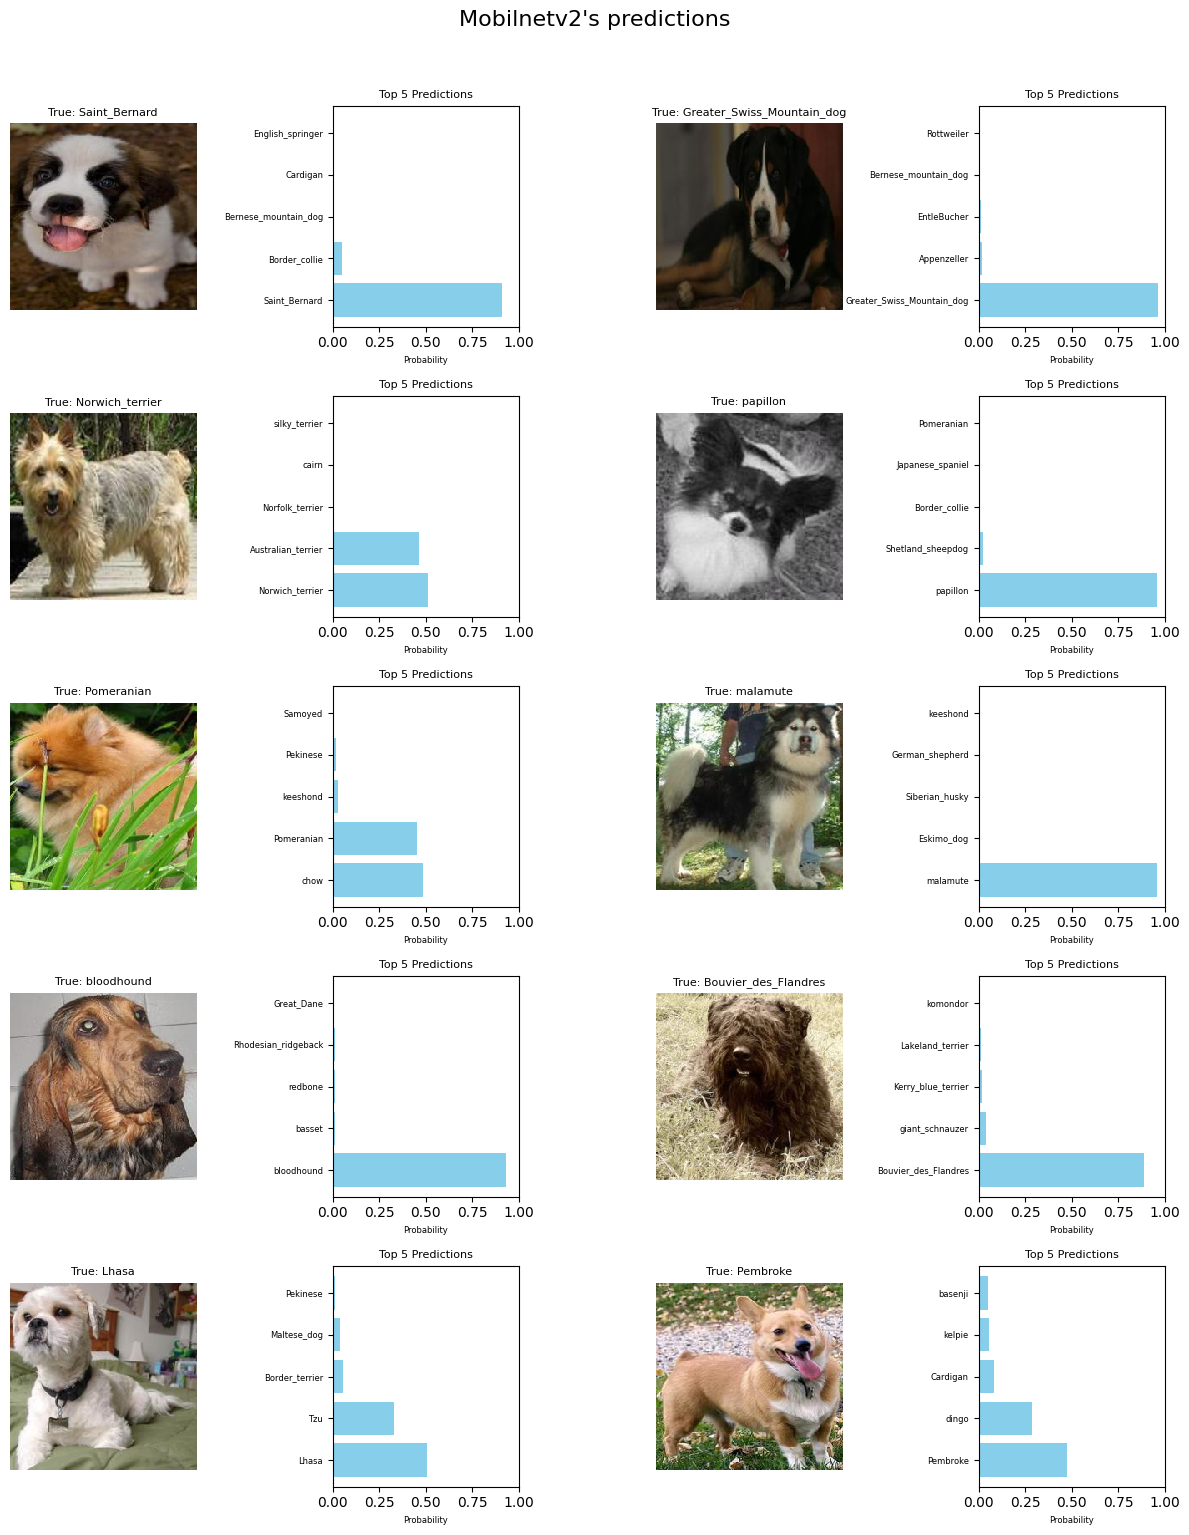

In [ ]:
# Visualize random predictions with plots
visualize_random_predictions(mobilenet_v2_model, test_loader, labels_r, device, num_images=10, global_title="Mobilnetv2's predictions")

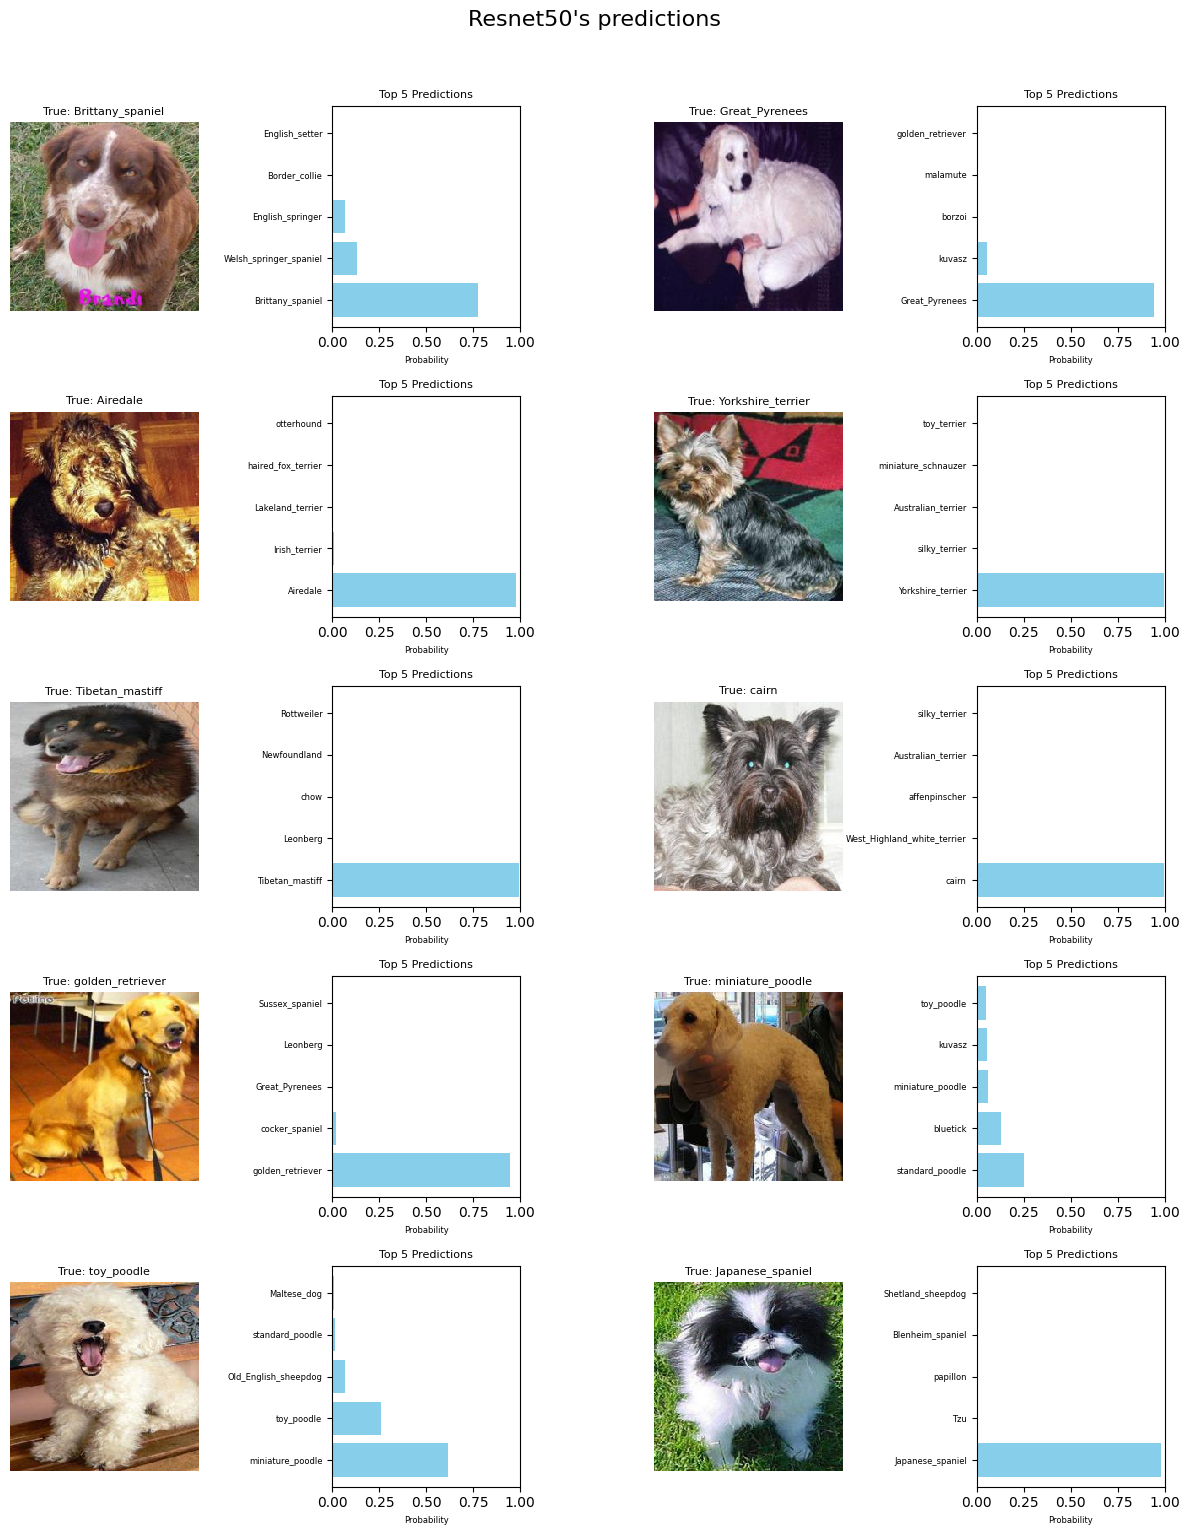

In [ ]:
visualize_random_predictions(resnet50_model, test_loader, labels_r, device, num_images=10,global_title="Resnet50's predictions")

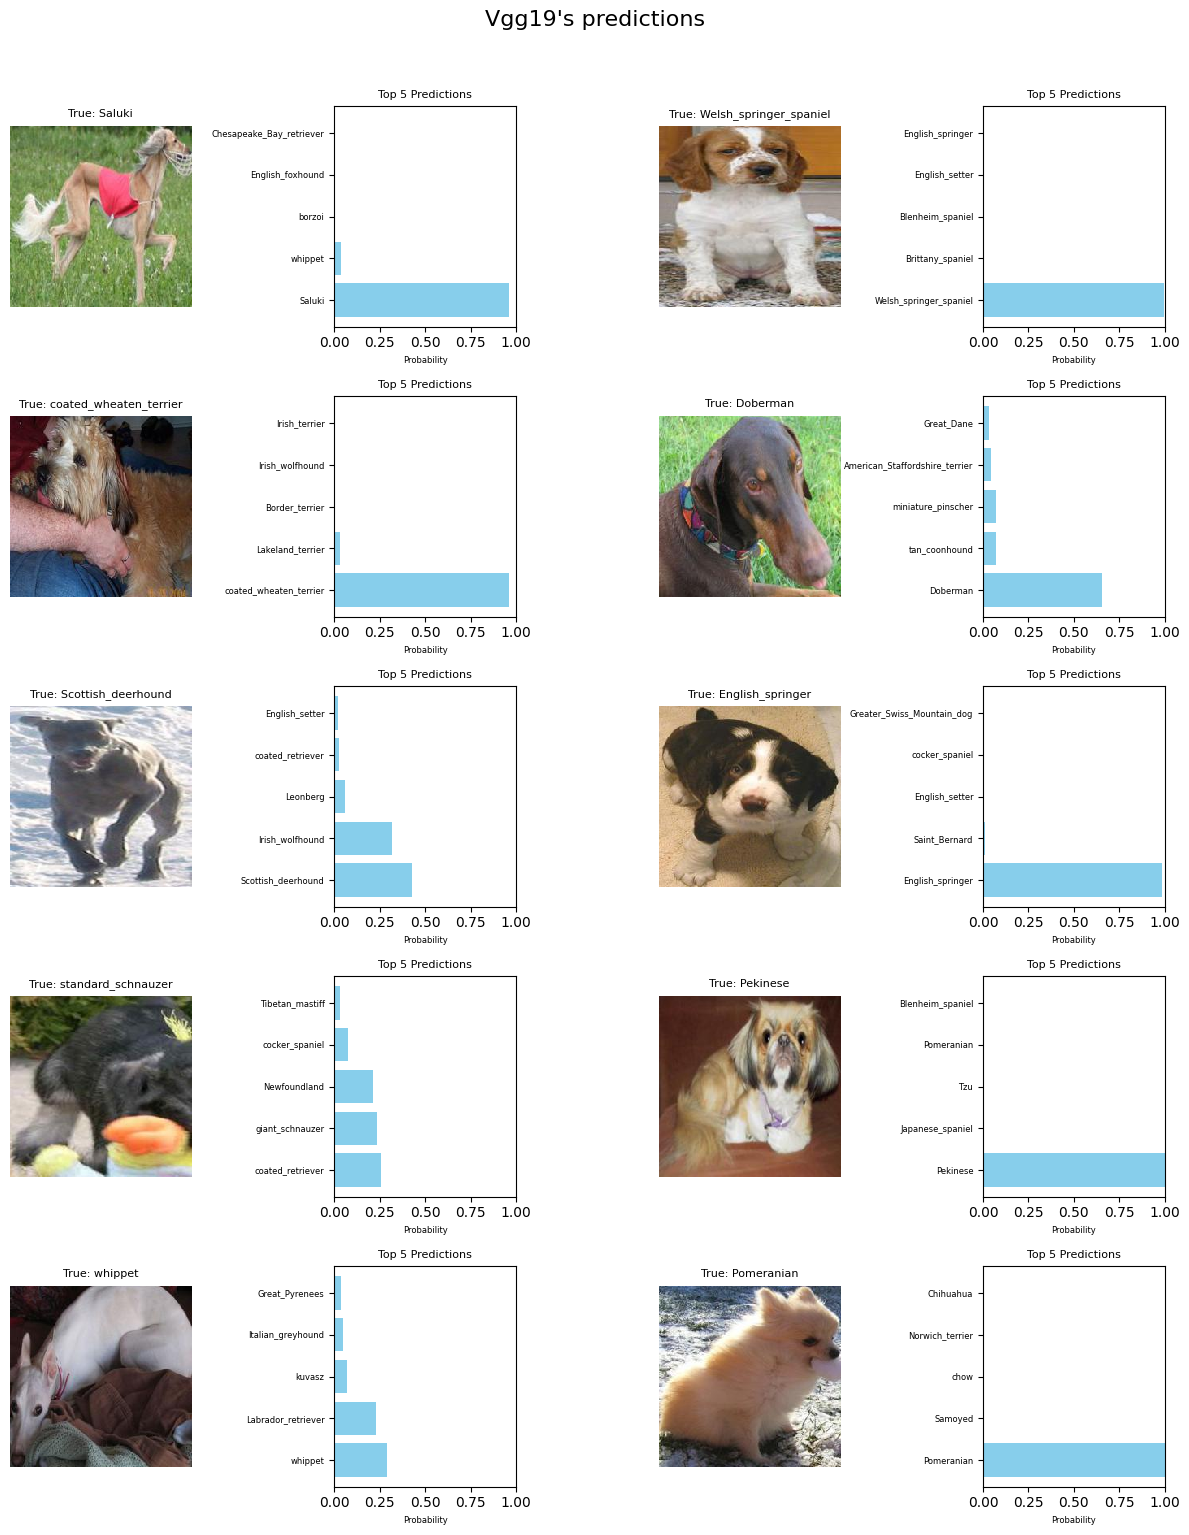

In [ ]:
visualize_random_predictions(vgg19_model, test_loader, labels_r, device, num_images=10,global_title="Vgg19's predictions")

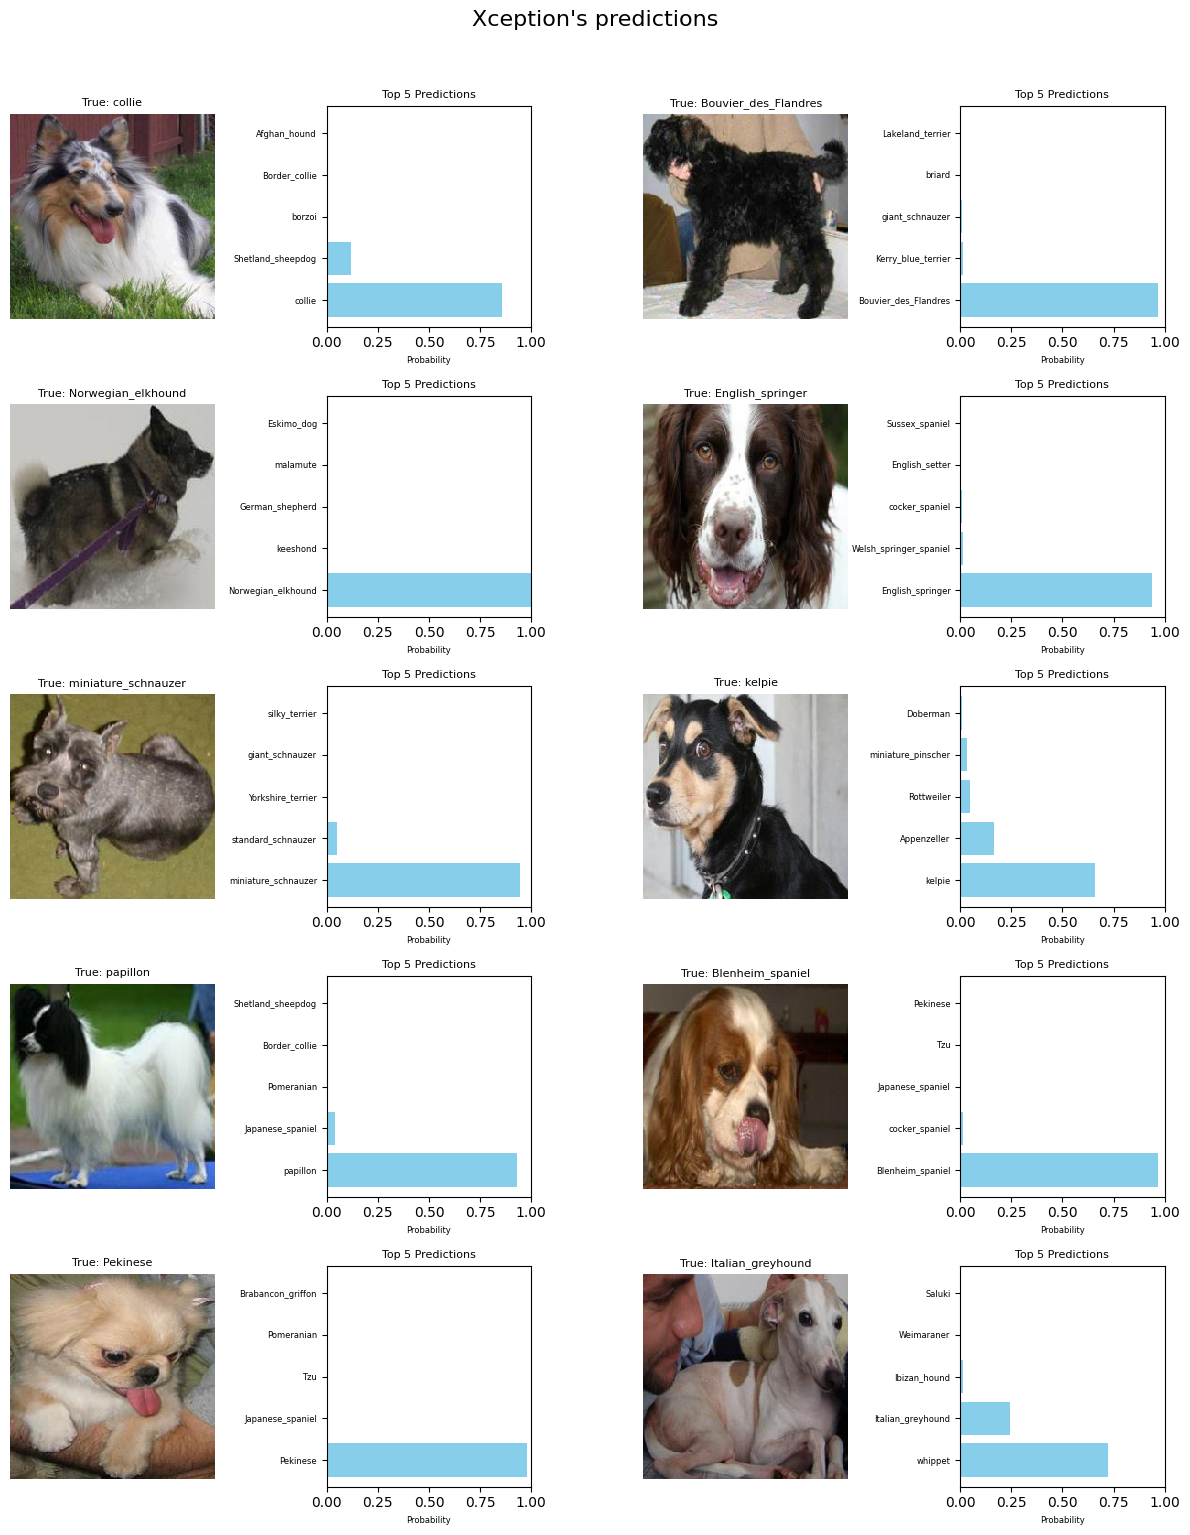

In [ ]:
visualize_random_predictions(xception_model, test_loader, labels_r, device, num_images=10,global_title="Xception's predictions")